In [148]:
import numpy as np
import pandas as pd
import pickle
#from build_database import flux_obj
from scipy import interpolate
import matplotlib.pyplot as plt
import os
import itertools
import random
import os
import time
import datetime
import gzip

from spacepy import coordinates as coord
from spacepy.time import Ticktock

from methods.raytracer_utils import readdump, read_rayfile, read_rayfiles
from mpl_toolkits.mplot3d import Axes3D

import methods.xflib as xflib

xf = xflib.xflib(lib_path='/shared/users/asousa/WIPP/WIPP_stencils/python/methods/libxformd.so')

R2D = 180./np.pi
D2R = np.pi/180.
#%matplotlib inline
%matplotlib nbagg
# Autoload changes made in external editor:
%load_ext autoreload
%autoreload 2
# --------------- Latex Plot Beautification --------------------------
fig_width = 8 
fig_height = 8
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'font.size': 14,
          'legend.fontsize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [352]:
crossing_dir = '../outputs/crossings/nightside/kp0/python_data/'
ray_dir = '../../rays/2d/nightside/mode6/kp0/'

latrange = [31, 32]
frange   = [200, 230]

# Ltargs = np.array([2.0, 2.1, 2.2, 2.3, 2.4])
Llims = [1.2, 8]
L_step = 0.1
Ltargs = np.arange(Llims[0], Llims[1], L_step)

d = os.listdir(crossing_dir)
avail_files = [x[:-5] for x in d if x.startswith('crossing_log') and x.endswith('.pklz')]

latpairs = np.array([x.split('_')[3].split('-') for x in avail_files], dtype=int)
freqpairs = np.array([x.split('_')[5].split('-') for x in avail_files], dtype=int)

unique_lats  = np.unique(latpairs)
unique_freqs = np.unique(freqpairs)




# mask off the ones we want to look at:
unique_lats = unique_lats[(unique_lats >= latrange[0]) & (unique_lats <= latrange[1])]
unique_freqs= unique_freqs[(unique_freqs >= frange[0]) & (unique_freqs <= frange[1])]

latpairs = zip(unique_lats[:-1], unique_lats[1:])
freqpairs = zip(unique_freqs[:-1], unique_freqs[1:])

crossings = [[] for l in Ltargs]
# for l in Ltargs:
#     crossings[l] = []

with open('test_dump.pkl','rb') as file:
    data = pickle.load(file)
    for fl in data['fieldlines']:
        Lk = np.argmin(np.abs(Ltargs - fl['L']))
        # Latitudes which have crossings logged:
        # ("but python is so readable!")
        crossings[Lk].append(fl['lat'][np.nonzero(np.array([len(k) for k in fl['crossings']]))[0]])
        print fl['alpha_lc']
# print crossings

# for f1,f2 in freqpairs:
#     for lat1, lat2 in latpairs:
#         fname = os.path.join(crossing_dir, 'crossing_log_lat_%d-%d_f_%d-%d.pklz'%(lat1, lat2, f1, f2))
#         with gzip.open(fname,'rb') as file:
#             print fname
#             data = pickle.load(file)
#             for fl in data['fieldlines']:
#                 if fl['L'] in Ltargs:
# #                     print fl['L']
# #                     print fl['crossings']
# #                     print len(fl['crossings']), len(fl['lat'])

# #                     print np.array(fl['crossings'])[:,0:2]
#                     crossings.append(np.array(fl['crossings'])[:,0:2])
# #                     have_crossings = [(len(x) > 0) for x in fl['crossings']]
# #                     crossings[fl['L']].extend(fl['lat'][have_crossings])
            


OSError: [Errno 2] No such file or directory: '../outputs/crossings/nightside/kp0/python_data/'

['lat', 'lon']


<IPython.core.display.Javascript object>


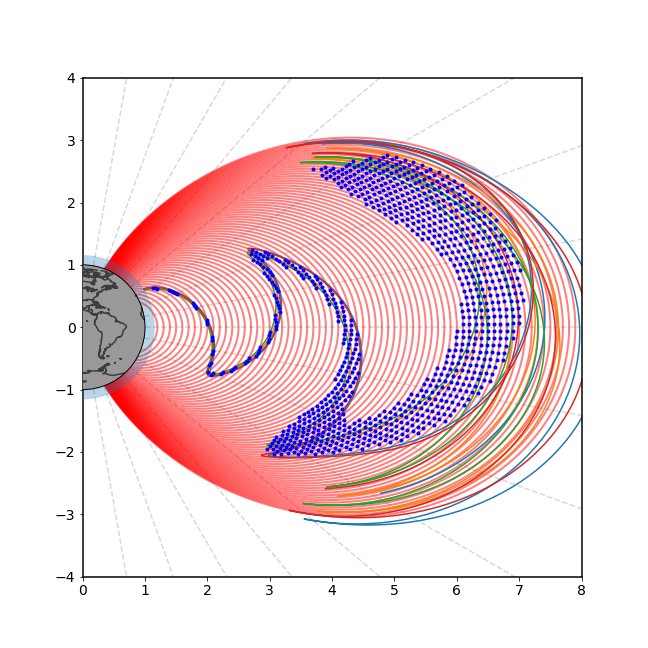

In [338]:
# Load coastlines (for plotting)
with gzip.open('methods/mag_coastlines.gzip','rb') as file:
    coast = pickle.load(file)
print coast.keys()

# Load some rays to compare against:

ray_dir = '../../rays/2d/dayside/mode6/kp0/'
R_E = 6371e3
rayze_lo = read_rayfiles(ray_dir, frange[0], latrange[0],latrange[1], 0, 360)
rayze_hi = read_rayfiles(ray_dir, frange[1], latrange[0],latrange[1], 0, 360)
itime = datetime.datetime(2010,1,1,0,0,0)






fig, ax = plt.subplots(1,1)
ax.set_aspect('equal')
[i.set_linewidth(1.5) for i in ax.spines.itervalues()] # thick plot border
# Draw the earth
# Plot the earth
earth = plt.Circle((0,0),1,facecolor='0.6',alpha=1,edgecolor='k', zorder=100)
iono  = plt.Circle((0,0),1 + 1000./6378.,alpha=0.3, zorder=99)
 
ax.add_patch(earth)                    # The earth (round)
ax.add_patch(iono)
coastpoints = np.vstack([coast['lon']/90. + 0.3, coast['lat']/90.])
coastr = np.linalg.norm(coastpoints, axis=0)
coastmask = (coastr < 1) | (np.isnan(coastr))
ax.plot(coastpoints[0,coastmask], coastpoints[1,coastmask],'k', zorder=101, alpha=0.6)

# Plot latitude lines:

for la in np.arange(-80, 81, 10):
    rr = np.array([1,10])
    plt.plot(rr*np.cos(la*D2R), rr*np.sin(la*D2R),'--',color='grey', alpha=0.3)
    

# Plot the fieldlines
for L in Ltargs:
    lam = np.linspace(-80,80,181)
    L_r = L*pow(np.cos(lam*D2R),2)
    Lx  = L_r*np.cos(lam*D2R)
    Ly  = L_r*np.sin(lam*D2R)
    ax.plot(Lx,Ly,color='r',linewidth=2,alpha=0.5)  # Field line
    
Lmax = max(Ltargs)
p = Lmax + 0.1
ax.set_xlim([0,p])
ax.set_ylim([-p/2,p/2])

for rayze in [rayze_lo, rayze_hi]:
    for ray in rayze:
        rsph = np.array([xf.sm2rllmag(x, itime) for x in np.array(ray['pos'])])
        r = rsph[:,0]/R_E
        theta = rsph[:,1]

        x = r*np.cos(theta*D2R)
        y = r*np.sin(theta*D2R)
        ax.plot(x,y)



# Plot each crossing point:
for cr_ind, cr_lats in enumerate(crossings):
    Lsh = Ltargs[cr_ind]
    la = np.array(cr_lats)*D2R
    rr = Lsh*np.cos(la)**2
    xx = rr*np.cos(la)
    yy = rr*np.sin(la)
    ax.plot(xx,yy,'b.')




In [169]:
ray_dir = '../../rays/2d/nightside/mode6/kp0/'
R_E = 6371e3
rayze = read_rayfiles(ray_dir, frange[0], latrange[0], latrange[1], 0, 360)
itime = datetime.datetime(2010,1,1,0,0,0)
for ray in rayze:
    rsph = np.array([xf.sm2rllmag(x, itime) for x in np.array(ray['pos'])])
    r = rsph[0,:]/R_E
    theta = rsph[1,:]
    
    x = r*np.cos(theta)
    y = r*np.sin(theta)
    ax.plot(x,y)


In [250]:
happy_dots = np.array([[1.9659258262890684, -7.499999999999998, 0.4999999999999997],
[1.974370064785235, -6.500000000000008, 0.4999999999999971],
[2.016530096125062, -11.500000000000007, 0.5000000000000041],
[2.0016231763884824, -12.500000000000004, 0.499999999999999],
[2.0428840307723233, -15.5, 0.5000000000000053],
[2.1144711531372375, -16.5, 0.5000000000000058],
[2.1144711531372375, -16.5, 0.5000000000000058],
[2.249543648567274, -14.50000000000001, 0.5000000000000042],
[2.228600760842535, -15.500000000000004, 0.5000000000000091],
[2.249543648567274, -14.50000000000001, 0.5000000000000042]])
print happy_dots

[[  1.96592583  -7.5          0.5       ]
 [  1.97437006  -6.5          0.5       ]
 [  2.0165301  -11.5          0.5       ]
 [  2.00162318 -12.5          0.5       ]
 [  2.04288403 -15.5          0.5       ]
 [  2.11447115 -16.5          0.5       ]
 [  2.11447115 -16.5          0.5       ]
 [  2.24954365 -14.5          0.5       ]
 [  2.22860076 -15.5          0.5       ]
 [  2.24954365 -14.5          0.5       ]]


0
0
0
0
2
5
6
4
3
3
3
1
0
1
3
4
5
7
7
8
8
10
9
5
8
10
11
11
12
12
15
18
27
25
15
15
16
16
18
28
27
34
32
27
26
28
31
37
48
61
66
68
66
67
61
54
42
29
16
4
0
0
0
0
0
0
0
0


(80,)
[(1660.0, 18.5), (215.0, 20.5), (17395.0, 23.5), (2270.0, 12.5), (1040.0, 12.5), (250.0, 15.5), (27825.0, 18.5), (4250.0, 23.5), (27825.0, 19.5), (1040.0, 22.5), (1215.0, 13.5), (3635.0, 18.5), (5815.0, 18.5), (890.0, 12.5), (3105.0, 15.5), (2270.0, 24.5), (9300.0, 24.5), (6800.0, 18.5), (5815.0, 12.5), (7950.0, 16.5), (2270.0, 13.5), (555.0, 23.5), (2270.0, 20.5), (250.0, 17.5), (1215.0, 19.5), (20340.0, 12.5), (4970.0, 15.5), (27825.0, 15.5), (3635.0, 20.5), (20340.0, 22.5), (890.0, 20.5), (9300.0, 23.5), (14875.0, 15.5), (17395.0, 19.5), (250.0, 20.5), (1420.0, 24.5), (215.0, 19.5), (2655.0, 14.5), (2270.0, 19.5), (17395.0, 13.5), (1940.0, 19.5), (10875.0, 23.5), (1940.0, 12.5), (295.0, 13.5), (12715.0, 22.5), (20340.0, 13.5), (4970.0, 23.5), (215.0, 24.5), (14875.0, 24.5), (4250.0, 13.5), (7950.0, 13.5), (5815.0, 17.5), (14875.0, 20.5), (6800.0, 22.5), (1940.0, 17.5), (250.0, 16.5), (4250.0, 18.5), (295.0, 16.5), (1660.0, 17.5), (4250.0, 12.5), (475.0, 17.5), (3105.0, 14.5), 

<IPython.core.display.Javascript object>


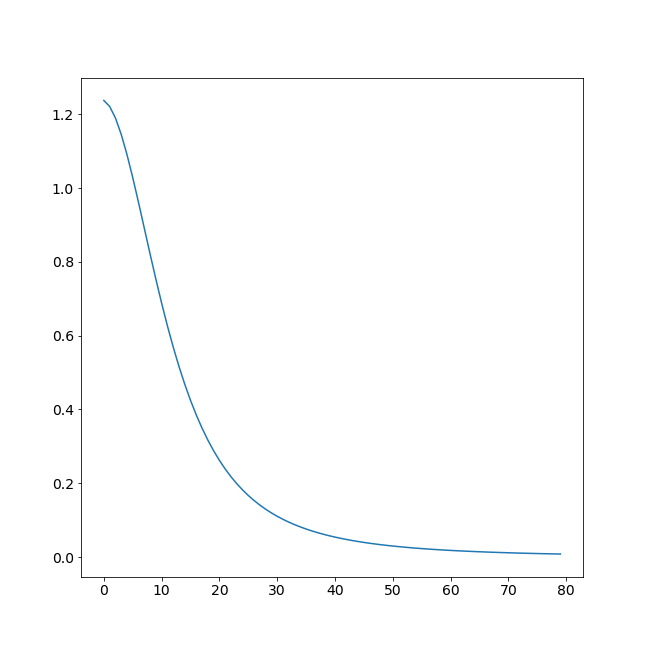

In [345]:
with gzip.open('../../lightning_power_study/outputs/input_powers/input_energy_15_0.pklz','rb') as file:
    indb = pickle.load(file)
print np.shape(indb[(1660.0, 18.5)])
print indb.keys()
plt.figure()
plt.plot(indb[(1660.0, 18.5)])

In [364]:
with open('test_dump.pkl','rb') as file:
    data = pickle.load(file)
    for fl in data['fieldlines']:
        Lk = np.argmin(np.abs(Ltargs - fl['L']))
        print fl['L']
        # Latitudes which have crossings logged:
        # ("but python is so readable!")
        crossings[Lk].append(fl['lat'][np.nonzero(np.array([len(k) for k in fl['crossings']]))[0]])
        for row in fl['crossings']:
            if len(row) > 0:
                print np.shape(row)

1.2
1.3
1.4
1.5
1.6
1.7
(20, 5)
(20, 5)
(7, 5)
1.8
(3, 5)
(20, 5)
(20, 5)
(20, 5)
(7, 5)
1.9
(2, 5)
(21, 5)
(20, 5)
(7, 5)
2.0
(1, 5)
(20, 5)
(13, 5)
2.1
(20, 5)
(11, 5)
2.2
(19, 5)
(10, 5)
2.3
(10, 5)
(8, 5)
2.4
(4, 5)
2.5
(12, 5)
(4, 5)
2.6
(16, 5)
(22, 5)
2.7
(16, 5)
(21, 5)
(1, 5)
2.8
(8, 5)
(20, 5)
(21, 5)
2.9
(15, 5)
(21, 5)
(20, 5)
(2, 5)
3.0
(14, 5)
(21, 5)
(22, 5)
(10, 5)
3.1
(17, 5)
(22, 5)
(21, 5)
(9, 5)
(1, 5)
3.2
(16, 5)
(21, 5)
(24, 5)
(20, 5)
(6, 5)
(1, 5)
3.3
(10, 5)
(17, 5)
(22, 5)
(24, 5)
(23, 5)
(6, 5)
(3, 5)
3.4
(8, 5)
(12, 5)
(22, 5)
(18, 5)
(6, 5)
(3, 5)
(1, 5)
3.5
(6, 5)
(14, 5)
(26, 5)
(13, 5)
3.6
(1, 5)
(7, 5)
(22, 5)
(30, 5)
(25, 5)
3.7
(1, 5)
(4, 5)
(19, 5)
(22, 5)
(26, 5)
(23, 5)
(11, 5)
3.8
(2, 5)
(12, 5)
(25, 5)
(24, 5)
(25, 5)
(19, 5)
(2, 5)
3.9
(1, 5)
(6, 5)
(22, 5)
(24, 5)
(24, 5)
(23, 5)
(12, 5)
4.0
(1, 5)
(4, 5)
(21, 5)
(23, 5)
(23, 5)
(25, 5)
(19, 5)
(11, 5)
4.1
(3, 5)
(14, 5)
(24, 5)
(24, 5)
(24, 5)
(23, 5)
(20, 5)
(12, 5)
4.2
(2, 5)
(5, 5)
(22, 5)


In [368]:
def calc_pitch_angle_change(inp_pwr, fieldlines, da_N, da_S):

    # Constants
    Hz2Rad = 2.*np.pi
    D2R = np.pi/180.
    H_IONO_BOTTOM = 1e5
    H_IONO_TOP = 1e6
    R_E = 6371e3
    Q_EL = 1.602e-19
    M_EL = 9.1e-31
    E_EL = 5.105396765648739E5 
    MU0  = np.pi*4e-7
    EPS0 = 8.854E-12
    C    = 2.997956376932163e8
    B0   = 3.12e-5



    # fieldlines is a list of dictionaries with the following:
    #['stixR', 'stixP', 'hit_counts', 'x_unit_vect', 'vol', 'total_vol', 
    #'crossings', 'y_unit_vect', 'L', 'pos', 'mu', 'lat', 'ftc_s', 'R', 'y', 'x', 'ftc_n', 'xradius', 'stixL']
    
    # Loop over field lines
    for fl_ind, fl in enumerate(fieldlines):
        # Which segments have crossings at them?
        L = fl['L']

        # Loop over EA segments
        lat_inds = np.where(fl['hit_counts'] > 0)[0]
        for lat_ind in lat_inds:
            lat = fl['lat'][lat_ind]

            slat = np.sin(lat*D2R)
            clat = np.cos(lat*D2R)
            slat_term = np.sqrt(1. + 3.*slat*slat)

            # Stix parameters
            stixP = fl['stixP'][lat_ind]
            stixR = fl['stixR'][lat_ind]
            stixL = fl['stixL'][lat_ind]

            # Other parameters which are a function of the EA segment only
            ftc_n = fl['ftc_n'][lat_ind]
            ftc_s = fl['ftc_s'][lat_ind]
            alpha_eq = fl['alpha_eq']
            alpha_lc = fl['alpha_lc'][lat_ind] 


            # Go through the crossings

            for row in fl['crossings'][lat_ind]:
                print row

            # stixS = ( stixR + stixL ) /2.0;
            # stixD = ( stixR - stixL ) /2.0;
            # stixA = stixS + (stixP-stixS)*cpsi_sq;
            # stixB = stixP*stixS+stixR*stixL+(stixP*stixS-stixR*stixL)*cpsi_sq;
            # stixX = stixP/(stixP- mu_sq*spsi_sq);




with open('test_dump.pkl','rb') as file:
    data = pickle.load(file)


calc_pitch_angle_change(1, data['fieldlines'], 0,0)


(0.10000000000000001, 200, 7.7515443236575862e-18, -26.644759366177304, 48.163526255493316)
(0.10000000000000001, 201, 7.7515443236575862e-18, -26.644759366177304, 48.163526255493316)
(0.10000000000000001, 203, 7.7515443236575862e-18, -26.644759366177304, 48.163526255493316)
(0.10000000000000001, 204, 7.7515443236575862e-18, -26.644759366177304, 48.163526255493316)
(0.10000000000000001, 206, 7.7515443236575862e-18, -26.644759366177304, 48.163526255493316)
(0.10000000000000001, 207, 7.7515443236575862e-18, -26.644759366177304, 48.163526255493316)
(0.10000000000000001, 209, 7.7515443236575862e-18, -26.644759366177304, 48.163526255493316)
(0.10000000000000001, 210, 7.7515443236575862e-18, -26.644759366177304, 48.163526255493316)
(0.10000000000000001, 212, 7.7515443236575862e-18, -26.644759366177304, 48.163526255493316)
(0.10000000000000001, 213, 7.7515443236575862e-18, -26.644759366177304, 48.163526255493316)
(0.10000000000000001, 215, 7.7515443236575862e-18, -26.335112682681736, 47.25024

In [376]:
v = [1, 2,3,3,3, 4, 5, 6, 8, 9, 9, 9]

vinds, vcounts = np.unique(v, return_counts=True)
x = np.zeros_like(v)

x[vinds] += vcounts
print x


[0 1 1 3 1 1 1 0 1 3 0 0]
